In [1]:
import rosbag
from sensor_msgs import point_cloud2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import struct
from sklearn.cluster import DBSCAN
from nlos_sensing import line_by_2p, intersection_of_2line, line_by_vertical_coef_p, parallel_line_distance, point2line_distance

In [2]:
file_path = "/home/agent/Code/ackermann_car_nav/data/20230626/exp02_2023-06-26-19-23-05"
bag = rosbag.Bag(f"{file_path}.bag")
bag_data = bag.read_messages(topics=['/laser_point_cloud', '/laser_point_cloud2', '/mmwave_radar_point_cloud', '/mmwave_radar_raw_data'])
frame_bytes = 196608

# 我原来想获取同一个时刻下的所有topic，才发现原来各个传感器时间是不一样的，没有任何消息是同时出现的，所以一定有先后时间顺序
laser_list, laser_list2, mmwave_list, mmwave_raw_list = [], [], [], []
for topic, msg, t in bag_data:
    if topic == '/laser_point_cloud':
        points = point_cloud2.read_points_list(
            msg, field_names=['x', 'y']
        )
        x_pos = [p.x for p in points]
        y_pos = [p.y for p in points]
        point_cloud = np.array([x_pos, y_pos]).T
        laser_list.append((t.to_sec(), msg.header.stamp.to_sec(), point_cloud))
    if topic == '/laser_point_cloud2':
        points = point_cloud2.read_points_list(
            msg, field_names=['x', 'y']
        )
        x_pos = [p.x for p in points]
        y_pos = [p.y for p in points]
        point_cloud = np.array([x_pos, y_pos]).T
        laser_list2.append((t.to_sec(), msg.header.stamp.to_sec(), point_cloud))
    if topic == '/mmwave_radar_point_cloud':
        points = point_cloud2.read_points_list(
            msg, field_names=['x', 'y', 'z', 'vel', 'snr']
        )
        x_pos = [p.x for p in points]
        y_pos = [p.y for p in points]
        z_pos = [p.z for p in points]
        vel = [p.vel for p in points]
        snr = [p.snr for p in points]
        point_cloud = np.array([x_pos, y_pos, z_pos, vel, snr]).T
        mmwave_list.append((t.to_sec(), msg.header.stamp.to_sec(), point_cloud))
    if topic == '/mmwave_radar_raw_data':
        adc_pack = struct.pack(f">{frame_bytes}b", *msg.data)
        adc_unpack = np.frombuffer(adc_pack, dtype=np.int16)
        mmwave_raw_list.append((t.to_sec(), msg.header.stamp.to_sec(), adc_unpack))
len(mmwave_list), len(mmwave_raw_list), len(laser_list), len(laser_list2)

(168, 168, 167, 165)

In [3]:
## 小车数据和GT时间对齐
# 比谁小，谁小谁就是要遍历的对象
def align(list1, list2, k=0, j=0):
    len_diff = min(len(list1), len(list2))
    minv, mini = np.inf, 0
    # 谁先曝光，谁就从头开始遍历，寻找距离对方开头时间最接近的
    if list1[0][k] < list2[0][j]:
        for i in range(len_diff):
            diff = np.abs(list1[i][k]-list2[0][j])
            if diff < minv:
                minv = diff
                mini = i
        list1 = list1[mini:]
    elif list1[0][k] > list2[0][j]:
        for i in range(len_diff):
            diff = np.abs(list2[i][k]-list1[0][j])
            if diff < minv:
                minv = diff
                mini = i
        list2 = list2[mini:]
    len_min = min(len(list1), len(list2))
    return list1[:len_min], list2[:len_min], minv, mini


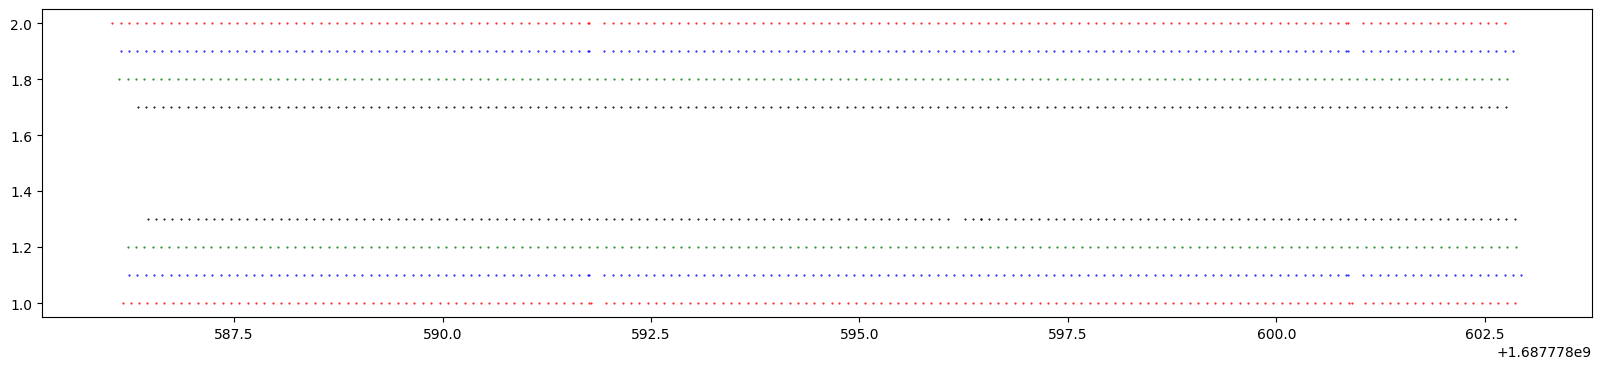

In [4]:
mmwave_t = np.array([t for t, stamp, pc in mmwave_list])
mmwave_stamp = np.array([stamp for t, stamp, pc in mmwave_list])
mmwave_raw_t = np.array([t for t, stamp, raw in mmwave_raw_list])
mmwave_raw_stamp = np.array([stamp for t, stamp, raw in mmwave_raw_list])
laser_t = np.array([t for t, stamp, pc in laser_list])
laser_stamp = np.array([stamp for t, stamp, pc in laser_list])
laser2_t = np.array([t for t, stamp, pc in laser_list2])
laser2_stamp = np.array([stamp for t, stamp, pc in laser_list2])

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(mmwave_t, np.ones(len(mmwave_t)), 'or', ms=0.5)
ax.plot(mmwave_stamp, np.ones(len(mmwave_stamp))*2, 'or', ms=0.5)
ax.plot(mmwave_raw_t, np.ones(len(mmwave_raw_t))*1.1, 'ob', ms=0.5)
ax.plot(mmwave_raw_stamp, np.ones(len(mmwave_raw_stamp))*1.9, 'ob', ms=0.5)
ax.plot(laser_t, np.ones(len(laser_t))*1.2, 'og', ms=0.5)
ax.plot(laser_stamp, np.ones(len(laser_stamp))*1.8, 'og', ms=0.5)
ax.plot(laser2_t, np.ones(len(laser2_t))*1.3, 'ok', ms=0.5)
ax.plot(laser2_stamp, np.ones(len(laser2_stamp))*1.7, 'ok', ms=0.5)

In [5]:
# 先让两个激光雷达对齐
# 再让毫米波雷达和一个激光雷达对齐，再让毫米波雷达和另一个激光雷达对齐
# 再让毫米波和点云对齐
laser_list, laser_list2, minv, mini = align(laser_list, laser_list2, k=1, j=1)
if len(mmwave_list) < len(mmwave_raw_list):
    laser_list, mmwave_list, minv2, mini2 = align(laser_list, mmwave_list, k=1, j=1)
    laser_list2, mmwave_list, minv3, mini3 = align(laser_list2, mmwave_list, k=1, j=1)
    laser_list, mmwave_list, minv2, mini2 = align(laser_list, mmwave_list, k=1, j=1)
else:
    laser_list, mmwave_raw_list, minv2, mini2 = align(laser_list, mmwave_raw_list, k=1, j=1)
    laser_list2, mmwave_raw_list, minv3, mini3 = align(laser_list2, mmwave_raw_list, k=1, j=1)
    laser_list, mmwave_raw_list, minv2, mini2 = align(laser_list, mmwave_raw_list, k=1, j=1)
mmwave_raw_list, mmwave_list, minv4, mini4 = align(mmwave_raw_list, mmwave_list, k=1, j=1)
print(len(mmwave_list), len(mmwave_raw_list), len(laser_list), len(laser_list2))

165 165 165 165


In [6]:
# data_list = [mmwave_list, mmwave_raw_list, laser_list, laser_list2]
# # 找到最早开始最晚结束的两个人进行align，这样一定是最短的
# latest_begin = np.argmax([
#     mmwave_stamp[0], mmwave_raw_stamp[0], laser_stamp[0], laser2_stamp[0]
# ])
# earliest_end = np.argmin([
#     mmwave_stamp[-1], mmwave_raw_stamp[-1], laser_stamp[-1], laser2_stamp[-1]
# ])
# print(latest_begin, earliest_end)
# # 如果是同一个人最晚开始最早结束
# if latest_begin == earliest_end:
#     pivot = latest_begin
#     for i in range(len(data_list)):
#         if i == pivot:
#             continue
#         data_list[i], data_list[pivot], _, _ = align(data_list[i], data_list[pivot], k=1, j=1)
# else:
#     data_list[latest_begin], data_list[earliest_end], _, _ = align(data_list[latest_begin], data_list[earliest_end], k=1, j=1)
#     pivot = latest_begin
#     for i in range(len(data_list)):
#         if i in [latest_begin, earliest_end]:
#             continue
#         else:
#             data_list[i], data_list[pivot], _, _ = align(data_list[i], data_list[pivot], k=1, j=1)
# mmwave_list, mmwave_raw_list, laser_list, laser_list2 = data_list
# len(mmwave_list), len(mmwave_raw_list), len(laser_list), len(laser_list2)

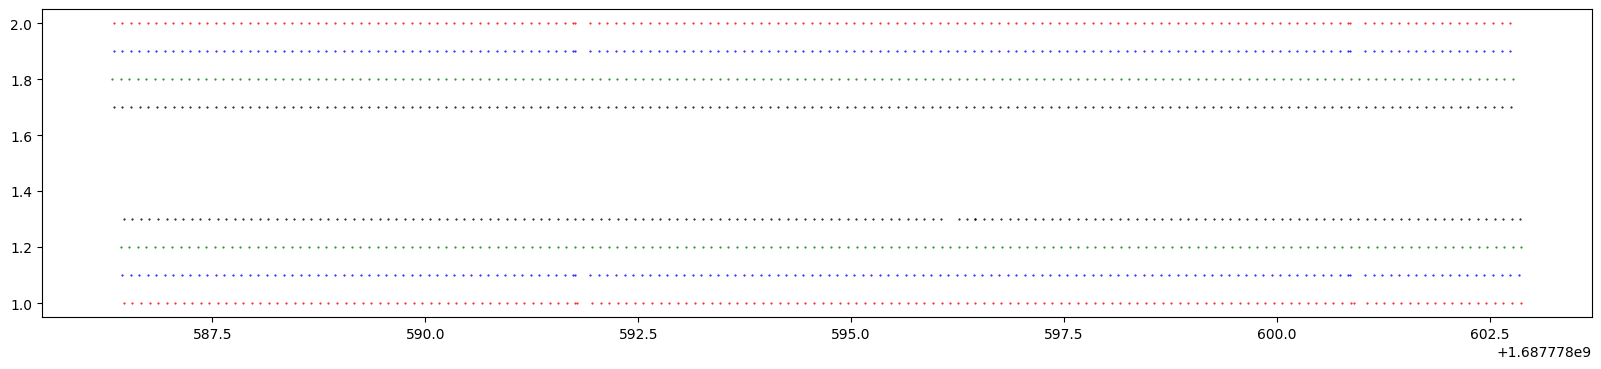

In [7]:
mmwave_t = np.array([t for t, stamp, pc in mmwave_list])
mmwave_stamp = np.array([stamp for t, stamp, pc in mmwave_list])
mmwave_raw_t = np.array([t for t, stamp, raw in mmwave_raw_list])
mmwave_raw_stamp = np.array([stamp for t, stamp, raw in mmwave_raw_list])
laser_t = np.array([t for t, stamp, pc in laser_list])
laser_stamp = np.array([stamp for t, stamp, pc in laser_list])
laser2_t = np.array([t for t, stamp, pc in laser_list2])
laser2_stamp = np.array([stamp for t, stamp, pc in laser_list2])

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(mmwave_t, np.ones(len(mmwave_t)), 'or', ms=0.5)
ax.plot(mmwave_stamp, np.ones(len(mmwave_stamp))*2, 'or', ms=0.5)
ax.plot(mmwave_raw_t, np.ones(len(mmwave_raw_t))*1.1, 'ob', ms=0.5)
ax.plot(mmwave_raw_stamp, np.ones(len(mmwave_raw_stamp))*1.9, 'ob', ms=0.5)
ax.plot(laser_t, np.ones(len(laser_t))*1.2, 'og', ms=0.5)
ax.plot(laser_stamp, np.ones(len(laser_stamp))*1.8, 'og', ms=0.5)
ax.plot(laser2_t, np.ones(len(laser2_t))*1.3, 'ok', ms=0.5)
ax.plot(laser2_stamp, np.ones(len(laser2_stamp))*1.7, 'ok', ms=0.5)

In [8]:
## 空间对齐
# 用laser2提取小车位姿
n_frame = 50
laser_n_frame = np.concatenate([p for t, t2, p in laser_list2[:n_frame]], axis=0)
local_sensing_range = [-2, 0, -2.75, -1]  # 切割小车
# local_sensing_range = [-2, 0, -2.9, -2]
flag_x = np.logical_and(laser_n_frame[:, 0]>=local_sensing_range[0], laser_n_frame[:, 0]<=local_sensing_range[1])
flag_y = np.logical_and(laser_n_frame[:, 1]>=local_sensing_range[2], laser_n_frame[:, 1]<=local_sensing_range[3])
flag = np.logical_and(flag_x, flag_y)
laser_part = laser_n_frame[flag]
laser_part.shape

(495, 2)

In [9]:
# 先聚类，提取小车的4条腿的点云，取平均
filter = DBSCAN(eps=0.03, min_samples=5)
db = filter.fit(laser_part)
labels = db.labels_
n_cluster = len(set(labels[labels>-1]))
n_cluster

5

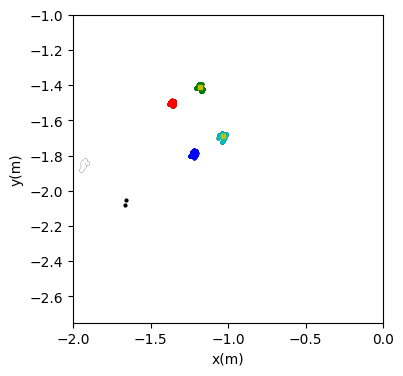

In [10]:
# 可视化小车的四条腿
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.set_xlim([local_sensing_range[0], local_sensing_range[1]])
ax.set_ylim([local_sensing_range[2], local_sensing_range[3]])
color_panel = ['ro', 'go', 'bo', 'co', 'wo', 'yo', 'mo', 'ko']
ax.plot(laser_part[:, 0], laser_part[:, 1], color_panel[-1], ms=2)

# 找距离原点最近的腿，认为是front_right
cluster_list = []
nearest_dist, nearest_idx = np.inf, -1
for i in range(n_cluster):
    cluster = laser_part[labels==i]
    center = np.mean(cluster, axis=0)
    if nearest_dist > np.linalg.norm(center):
        nearest_dist = np.linalg.norm(center)
        nearest_idx = i
    cluster_list.append(center)
    ax.plot(cluster[:, 0], cluster[:, 1], color_panel[i], ms=2)
front_right = cluster_list[nearest_idx]

# 找除front_right外x值最大的腿，认为是back_right
max_x, max_x_idx = -np.inf, -1
for i in range(n_cluster):
    if i == nearest_idx:
        continue
    if cluster_list[i][0] > max_x:
        max_x = cluster_list[i][0]
        max_x_idx = i
back_right = cluster_list[max_x_idx]

ax.plot(*front_right, 'sy', ms=3)
ax.plot(*back_right, 'sy', ms=3)

In [11]:
# 根据两条腿计算旋转角度
coef = line_by_2p(front_right, back_right)
theta = np.arctan(coef[0]) + np.pi if coef[0] < 0 else np.arctan(coef[0])
# 计算小车中心点在标定激光雷达坐标系下的位置
AD = 0.12
CD = 0.105
AB = back_right - front_right
OD = front_right + AB * AD / np.linalg.norm(AB)
coef1 = line_by_vertical_coef_p(coef, OD)
coef2a, coef2b = parallel_line_distance(coef, CD)
coef2 = coef2a if point2line_distance(coef2a, [0, 0]) > point2line_distance(coef2b, [0, 0]) else coef2b
inter = intersection_of_2line(coef1, coef2)
theta*180/np.pi, inter, np.linalg.norm(AB)

(116.92581713551594, array([-1.21703623, -1.56470824]), 0.31408202458022594)

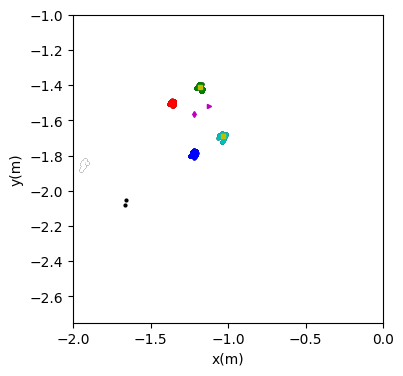

In [12]:
ax.plot(*OD, '>m', ms=3)
ax.plot(*inter, 'dm', ms=3)
fig

In [13]:
# 保存结果：时间、laser、laser2、毫米波点云、毫米波原始数据、小车位姿
transform = (inter, theta)
all_point_cloud = []
pad = 0
for i in range(pad, len(mmwave_list)-pad):
    tmp = (laser_list[i][1], laser_list[i][2], laser_list2[i][2], mmwave_list[i][2], mmwave_raw_list[i][2], transform)
    all_point_cloud.append(tmp)
with open(f"{file_path}.pkl", 'wb') as f:
    pickle.dump(all_point_cloud, f)